In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


In [2]:
import data1 as data
from sklearn.model_selection import train_test_split

x = data.x
y = data.y.filter(['sphere', 'worm', 'vesicle', 'other'], axis=1).replace(-1, 0)
vesicle = y['vesicle']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=0, stratify=y.other)
len(y_test), sum(y_test.other)

(30, 1)

In [3]:
from models import random_forest_pcc, random_forest_ind

random_forest_pcc.fit(x_train, y_train)
random_forest_ind.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                       random_state=RandomState(MT19937) at 0x12D178B40))

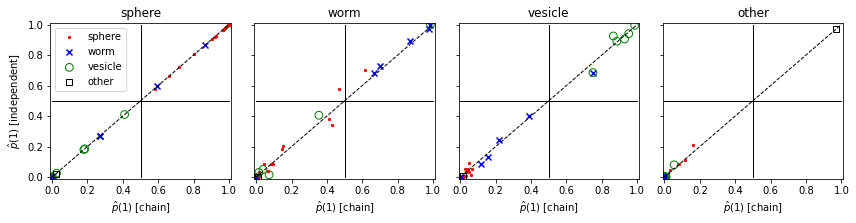

In [4]:
from matplotlib import pyplot as plt
from plotting import scatter_phases

fig, axs = plt.subplots(1, 4, figsize=(12, 3.2), tight_layout=True, sharey=True, sharex=True)

for i in range(4):
    axs[i].plot([0, 1], [0, 1], lw=1, ls='--', color='black')
    axs[i].plot([0, 1], [0.5, 0.5], lw=1, color='black')
    axs[i].plot([0.5, 0.5], [0, 1], lw=1, color='black')
    scatter_phases(y_test, random_forest_pcc.predict_proba(x_test)[:, i], random_forest_ind.predict_proba(x_test)[:, i], ax=axs[i])
    axs[i].set_xlabel(r'$\hat{p}(1)$ [chain]')
    axs[i].set_title(y_test.columns[i])

axs[0].set_ylabel(r'$\hat{p}(1)$ [independent]')
axs[2].set_xlim(-0.01, 1.01)
axs[2].set_ylim(-0.01, 1.01)
axs[0].legend()
plt.show()

In [5]:
query = (data.x.core_HPMA == 1) & (data.x.corona_GMA == 1) & (data.x.dp_corona==78) & (data.x.salt==0) & (data.x.ph==7) & (data.x.charged==0) & (data.x.temp==70)
sum(query), sum(~query)

(44, 548)

In [38]:
x_train, x_test, y_train, y_test = x[~query], x[query], y[~query], y[query]

random_forest_pcc.fit(x_train, y_train)
prototype = x_test.iloc[0]

prototype

clogp_corona                0.090000
mon_corona_mw             160.070000
mon_corona_apol            23.529516
mon_corona_mv               1.243700
mon_corona_psa             66.760000
dp_corona                  78.000000
corona_mw_total         12485.460000
corona_mv_total            97.008600
clogp_core                  1.100000
mon_core_mw               144.080000
mon_core_apol              22.727516
mon_core_mv                 1.185000
mon_core_psa               46.530000
dp_core                   150.000000
core_mw_total           21612.000000
core_mv_total             177.750000
ratio_mass                  0.366170
ratio_vol                   0.353068
conc                       10.000000
ph                          7.000000
salt                        0.000000
charged                     0.000000
temp                       70.000000
core_BzMA                   0.000000
core_DAAM                   0.000000
core_EGEMA                  0.000000
core_GlyMA                  0.000000
c

In [60]:
import numpy as np

xx1 = np.linspace(6, 28, 200)
xx2 = np.linspace(120, 530, 200)
xx1, xx2 = np.meshgrid(xx1, xx2, indexing='xy')

grid_points = data.x_grid_data(prototype, xx1, xx2)

yy_hat = random_forest_pcc.predict_proba(grid_points)


/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


In [59]:
from scipy.stats import entropy

y_hat_full = random_forest_pcc.predict_full_proba(x_test)
H = entropy(y_hat_full, axis=1)

In [23]:
entropy(yy_hat, axis=1)

array([0.68601337, 0.68601337, 0.68601337, ..., 0.87110522, 0.87110522,
       0.87110522])

In [62]:
yy_hat_sphere = yy_hat[:, 0].reshape(xx1.shape)
yy_hat_worm = yy_hat[:, 1].reshape(xx1.shape)
yy_hat_vesicle = yy_hat[:, 2].reshape(xx1.shape)
yy_hat_other = yy_hat[:, 3].reshape(xx1.shape)


In [63]:
(yy_hat_sphere.min(), yy_hat_sphere.max()), (yy_hat_worm.min(), yy_hat_worm.max()), (yy_hat_vesicle.min(), yy_hat_vesicle.max())

((0.165, 0.645),
 (0.019625, 0.783075),
 (0.004398749999999999, 0.45806849999999993))

/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/3033225119.py:2: UserWarning: No contour levels were found within the data range.
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/3033225119.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')


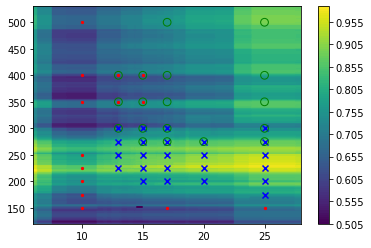

In [30]:
cp = plt.contourf(xx1, xx2, entropy(yy_hat, axis=1).reshape(xx1.shape), levels=100)
plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
scatter_phases(y_test, x_test['conc'], x_test['dp_core'])
plt.colorbar(cp)


/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/1163531861.py:2: UserWarning: No contour levels were found within the data range.
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/1163531861.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')


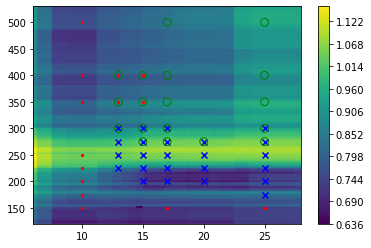

In [61]:
cp = plt.contourf(xx1, xx2, entropy(yy_hat, axis=1).reshape(xx1.shape), levels=100)
plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
scatter_phases(y_test, x_test['conc'], x_test['dp_core'])
plt.colorbar(cp)

In [52]:
x_test.index[np.argmax(H)]

535

In [65]:
import pandas as pd

def augment(est, x_train, x_test, y_train, y_test):
    H = entropy(est.predict_full_proba(x_test))
    max_entropy_idx = np.argmax(H)
    _x_test, _y_test = x_test.drop(x_test.index[max_entropy_idx]),  y_test.drop(y_test.index[max_entropy_idx])
    _x_train, _y_train = pd.concat((x_train, x_test.iloc[max_entropy_idx])), pd.concat((y_train ,y_test.iloc[max_entropy_idx]))
    return _x_train, _x_test, _y_train, _y_test


/usr/local/lib/python3.9/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


(                      clogp_corona  mon_corona_mw  mon_corona_apol  \
 1                             0.09         160.07        23.529516   
 2                             0.09         160.07        23.529516   
 3                             0.09         160.07        23.529516   
 4                             0.09         160.07        23.529516   
 5                             0.09         160.07        23.529516   
 ...                            ...            ...              ...   
 initiator_AIBA                 NaN            NaN              NaN   
 initiator_KPS/AscAc            NaN            NaN              NaN   
 initiator_V-501                NaN            NaN              NaN   
 initiator_VA-044               NaN            NaN              NaN   
 initiator_tBH-Na2SO3           NaN            NaN              NaN   
 
                       mon_corona_mv  mon_corona_psa  dp_corona  \
 1                            1.2437           66.76       56.0   
 2          

In [58]:
random_forest_pcc.fit(_x_train, _y_train)


In [56]:
_x_train

,clogp_corona,mon_corona_mw,mon_corona_apol,mon_corona_mv,mon_corona_psa,dp_corona,corona_mw_total,corona_mv_total,clogp_core,mon_core_mw,...,corona_QDMAEMA,corona_HPMAm,corona_KSPMA,corona_MAcEPyr,initiator_ACVA,initiator_AIBA,initiator_KPS/AscAc,initiator_V-501,initiator_VA-044,initiator_tBH-Na2SO3
Entry no,,,,,,,,,,,,,,,,,,,,,
1,0.09,160.07,23.529516,1.2437,66.76,56.0,8963.92,69.6472,1.10445,144.8997,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.09,160.07,23.529516,1.2437,66.76,56.0,8963.92,69.6472,1.10445,144.8997,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.09,160.07,23.529516,1.2437,66.76,56.0,8963.92,69.6472,1.10445,144.8997,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.09,160.07,23.529516,1.2437,66.76,56.0,8963.92,69.6472,1.10445,144.8997,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.09,160.07,23.529516,1.2437,66.76,56.0,8963.92,69.6472,1.10445,144.8997,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.09,160.07,23.529516,1.2437,66.76,54.0,8643.78,67.1598,1.10000,144.0800,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
590,0.09,160.07,23.529516,1.2437,66.76,37.0,5922.59,46.0169,1.10000,144.0800,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
591,0.09,160.07,23.529516,1.2437,66.76,54.0,8643.78,67.1598,1.10000,144.0800,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
